In [81]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Lambdad,
    Activations,
    ScaleIntensityRange,
    Lambda
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, SSIMMetric
from monai.losses import DiceLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import nrrd

print_config()

MONAI version: 1.2.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/erattakulangara/.conda/envs/Pytorch/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.1
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installatio

In [82]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = './Train'
print(root_dir)


./Train


In [94]:
train_images = sorted(
    glob.glob(os.path.join(root_dir, "RTrainVolumes", "*.nrrd")))[:25]
train_labels = sorted(
    glob.glob(os.path.join(root_dir, "RTrainLabels", "*.nrrd")))[:25]
data_dicts = [{"image": image_name, "label": label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-5], data_dicts[-5:]

In [95]:
print(len(train_files))

20


In [96]:
import nrrd
from monai.transforms import LoadImage
set_determinism(seed=0)

out = LoadImage(reader="NrrdReader")(
    "./Train/RTrainLabels/P10a.seg.nrrd")
out[0].shape

torch.Size([32, 256, 256])

In [97]:

from monai.transforms import Transposed
import numpy as np


def binarize(label, threshold=0.1):
    binary_mask = (label > threshold)
    binary_mask[binary_mask > 0] = 1  # Set all non-zero pixels to 1
    return binary_mask


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], reader="NrrdReader", image_only=True),
        Transposed(keys=['image', 'label'], indices=[2, 1, 0]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Lambdad(("label"), binarize),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 16),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],
                   reader="NrrdReader", image_only=True),
        Transposed(keys=['image', 'label'], indices=[2, 1, 0]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Lambdad(("label"), binarize),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)


In [98]:
check_ds = Dataset(data=val_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")


image shape: torch.Size([4, 1, 128, 128, 16]), label shape: torch.Size([4, 1, 128, 128, 16])


image shape: torch.Size([256, 256, 32]), label shape: torch.Size([256, 256, 32])
image max: 1.0, label max : True


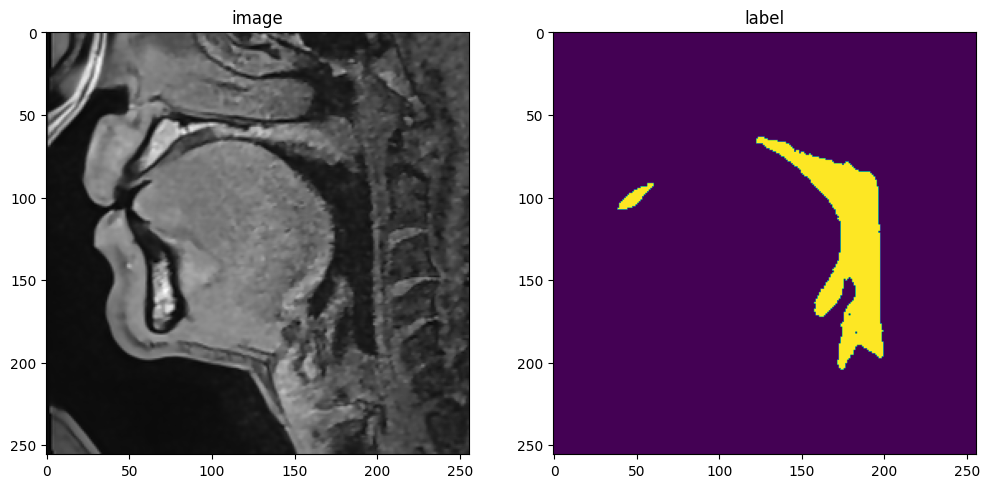

In [99]:
import numpy as np
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f"image max: {np.max(image)}, label max : {np.max(label)}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 10], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 10])
plt.show()


In [100]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)


Loading dataset: 100%|██████████| 5/5 [00:00<00:00, 19.04it/s]


In [101]:
#check cache dataset
# for item in train_loader:
#     print(item["label"].shape)

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA A10
Memory Usage:
Allocated: 0.1 GB
Cached:    2.0 GB


In [103]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [73]:
pre_trained_state_dict = torch.load(
    "/home/erattakulangara/hpchome/DeepLearningAlgo/2022_3D_Unet_segmentation/3D_Unet/ver_14.0_Train_CTData/Output/Models/OSIC_1000EP.pth")


In [74]:
model_state_dict = model.state_dict()

#update only if the shape matches
# Update the state dict to load only the compatible keys
for name, param in pre_trained_state_dict.items():
    if name in model_state_dict and param.shape == model_state_dict[name].shape:
        model_state_dict[name] = param


In [75]:
# Load the modified state dict into the UNet model
model.load_state_dict(model_state_dict)

# Set the last 5 layers to be trainable
total_layers = len(list(model.parameters()))
print(f"total_layers : {total_layers}")
for idx, (name, param) in enumerate(model.named_parameters()):
    if idx >= total_layers - 92:
        #print(f"Number of trainable layers {idx}")
        param.requires_grad = True
    else:
        print(f"Number of frozen layers {idx}")
        param.requires_grad = False

total_layers : 97
Number of frozen layers 0
Number of frozen layers 1
Number of frozen layers 2
Number of frozen layers 3
Number of frozen layers 4


In [104]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [105]:
out_root = "./NetworkOutput/Unet3DTrans/Models/"
max_epochs = 1500
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (128, 128, 16)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            #metric = 1-loss.item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    out_root, "Unet3D_1500EP_20Samples" + ".pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/1500
1/10, train_loss: 0.6253
2/10, train_loss: 0.6222
3/10, train_loss: 0.6295
4/10, train_loss: 0.5791
5/10, train_loss: 0.6563
6/10, train_loss: 0.6227
7/10, train_loss: 0.6077
8/10, train_loss: 0.6225
9/10, train_loss: 0.6210
10/10, train_loss: 0.5792
epoch 1 average loss: 0.6165
----------
epoch 2/1500
1/10, train_loss: 0.5936
2/10, train_loss: 0.6150
3/10, train_loss: 0.6007
4/10, train_loss: 0.5778
5/10, train_loss: 0.5975
6/10, train_loss: 0.6246
7/10, train_loss: 0.5870
8/10, train_loss: 0.6501
9/10, train_loss: 0.5534
10/10, train_loss: 0.5380
epoch 2 average loss: 0.5938
saved new best metric model
current epoch: 2 current mean dice: 0.0677
best mean dice: 0.0677 at epoch: 2
----------
epoch 3/1500
1/10, train_loss: 0.5818
2/10, train_loss: 0.5947
3/10, train_loss: 0.5766
4/10, train_loss: 0.5588
5/10, train_loss: 0.5300
6/10, train_loss: 0.5343
7/10, train_loss: 0.5875
8/10, train_loss: 0.5782
9/10, train_loss: 0.5394
10/10, train_loss: 0.5624
epoch 3 ave

In [78]:
# out = post_trans[0].cpu()
# print(np.unique(out[0][:,:,2]))
# plt.imshow(out[0][:,:,10])

In [79]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
#0.93 - Layer 10
#  

train completed, best_metric: 0.9215 at epoch: 856


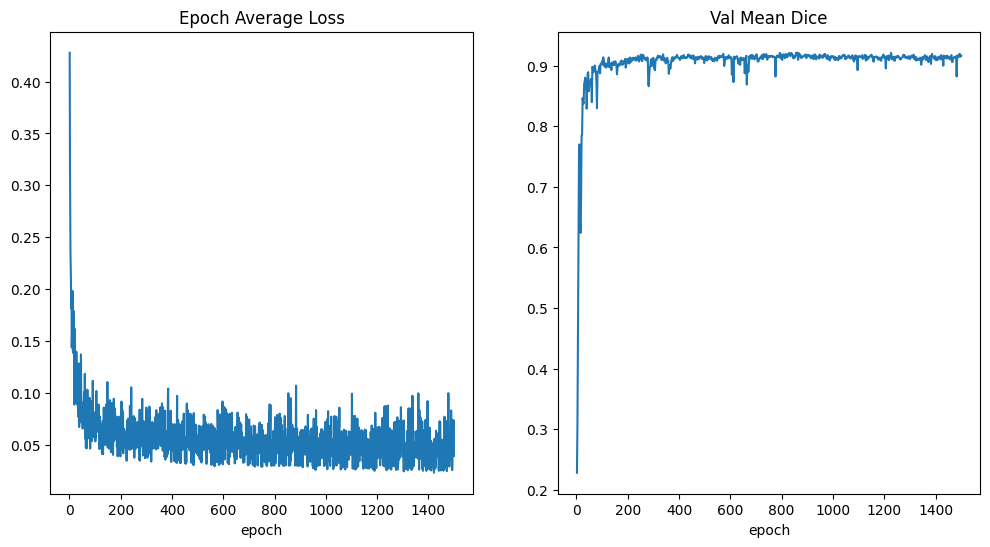

In [80]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


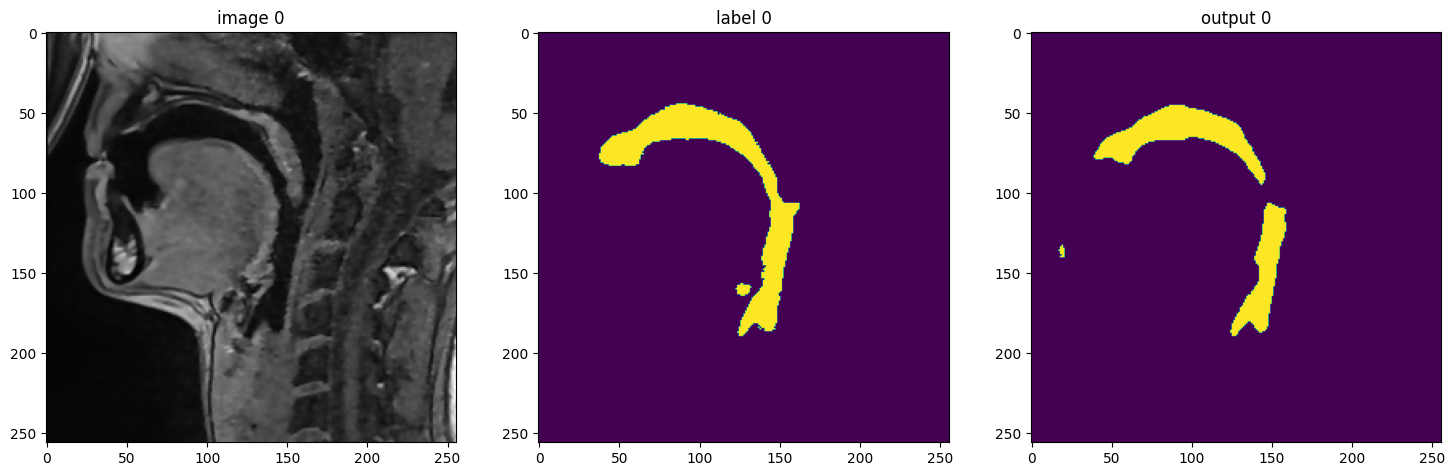

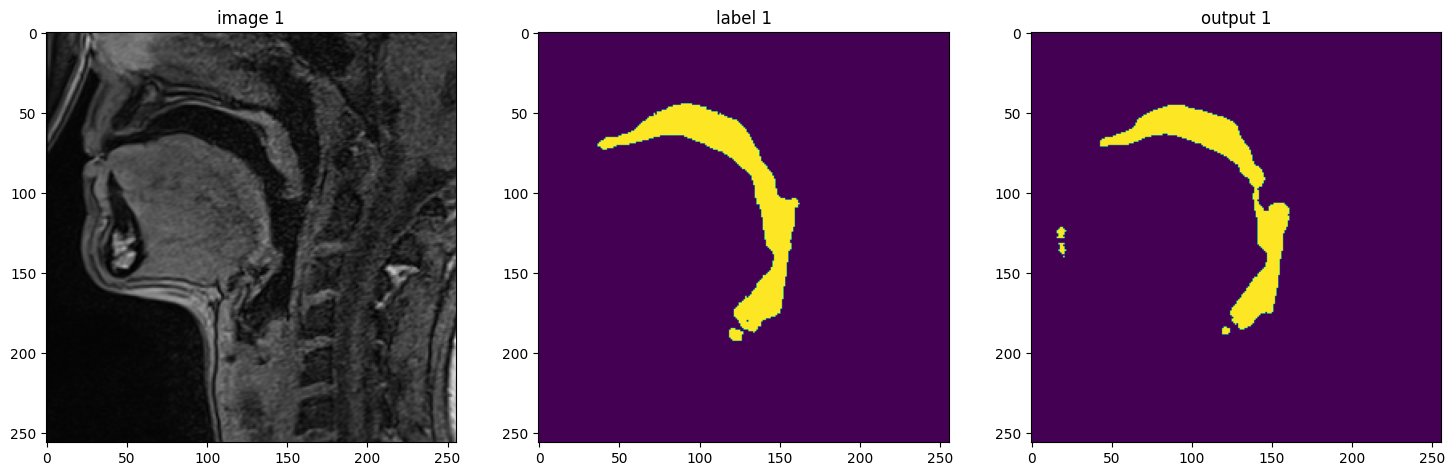

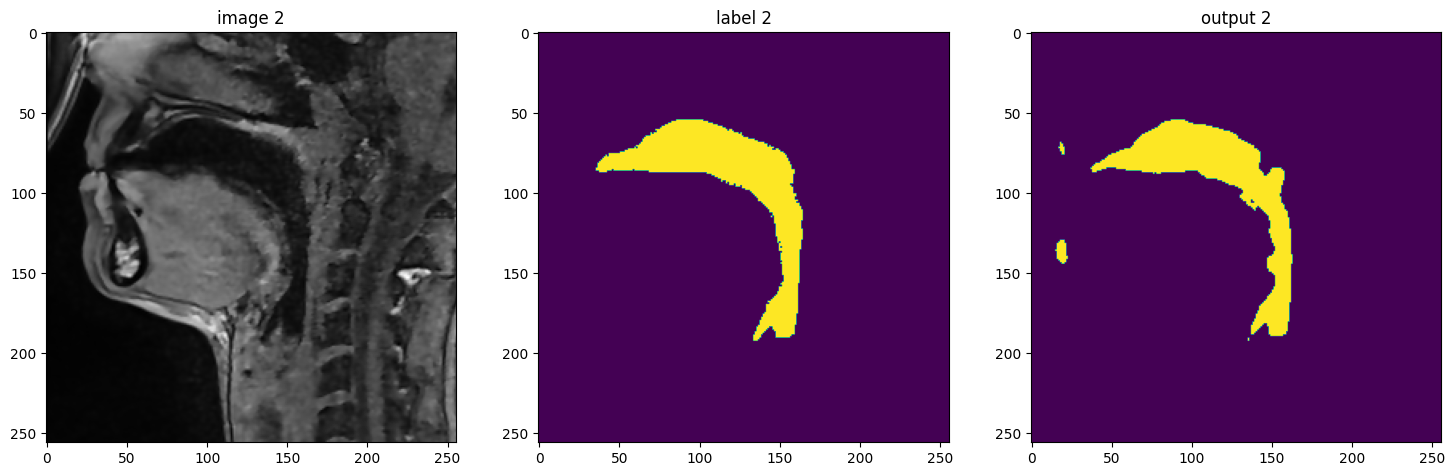

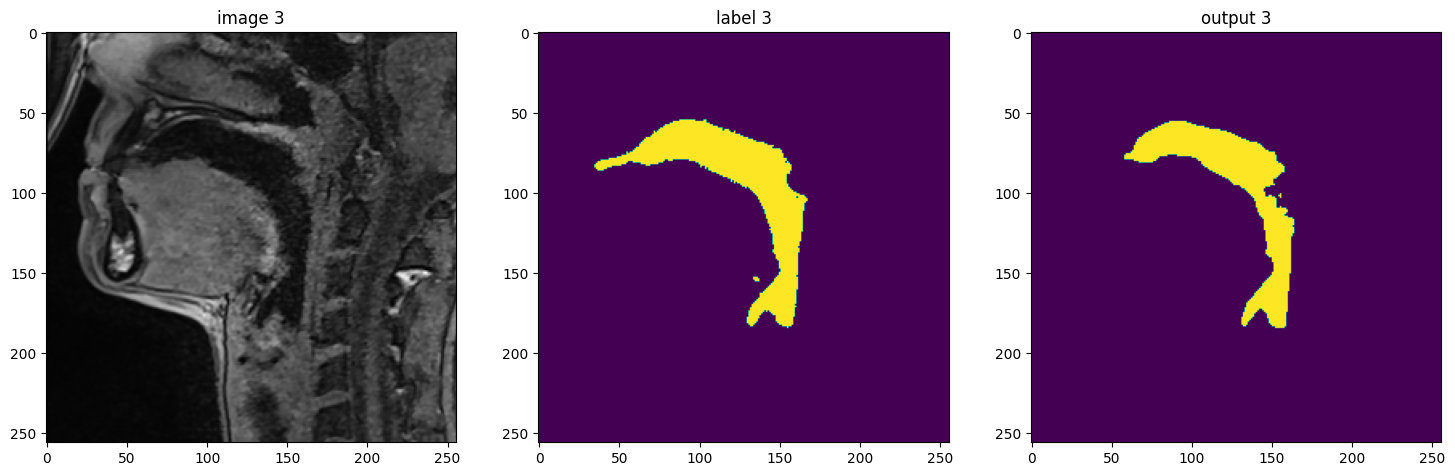

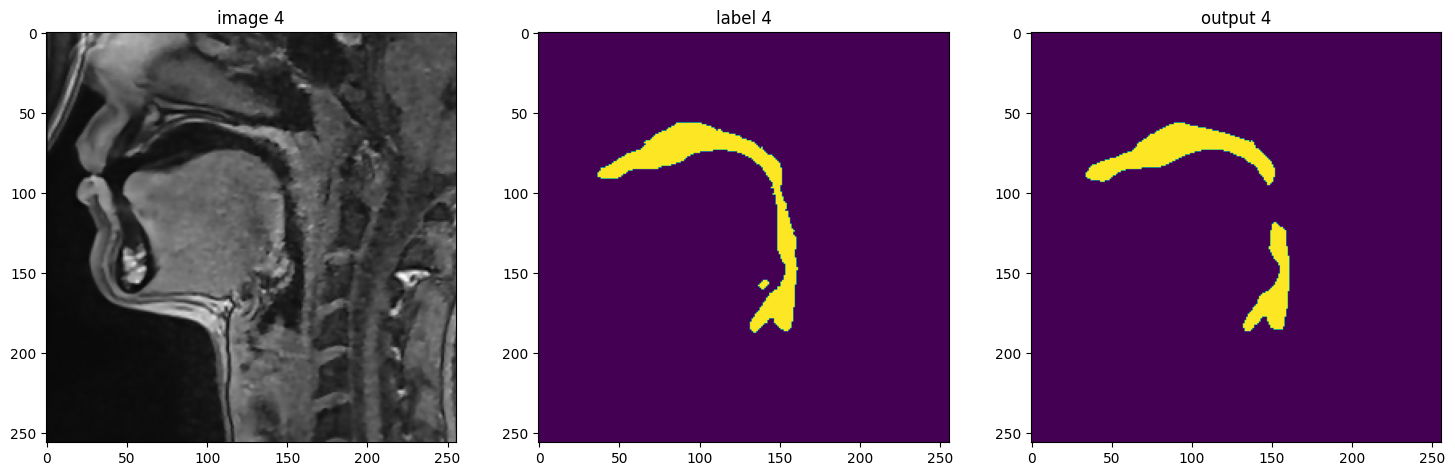

In [ ]:


model.load_state_dict(torch.load(
    os.path.join("./NetworkOutput/Unet3DTrans/Models/", "Trans_OSIC_model_1500EP_5Layers.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 10], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 10])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 10])
        plt.show()
    
